## Implementing a perceptron learning algorithm

### Loading in a dataset

First let's load in a dataset into a pandas dataframe

In [1]:
import pandas as pd

df = pd.read_csv('iris.data', header=None)

df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


Pandas dataframe objects are like a SQL table and provide efficient queries. They are built upon and designed to work with numpy arrays.

We want to work with just 2 dimensions of this dataset for now so it's easier to visualize and reason about. We'll use the sepal length and petal length from columns 0 and 2.

In [2]:
# Get the first 100 rows, selecting columns 0 and 2 (sepal and petal length)
sepal_petal_rows = df.iloc[0:100, [0, 2]].values

# in the dataset the first 50 rows are iris setosa, the next 50 are iris versicolor
setosa_rows = sepal_petal_rows[:50]
versicolor_rows = sepal_petal_rows[50:]

print(setosa_rows[:5])
print(versicolor_rows[:5])

[[ 5.1  1.4]
 [ 4.9  1.4]
 [ 4.7  1.3]
 [ 4.6  1.5]
 [ 5.   1.4]]
[[ 7.   4.7]
 [ 6.4  4.5]
 [ 6.9  4.9]
 [ 5.5  4. ]
 [ 6.5  4.6]]


### Visualizing 2 classes 

Plotting the two classes on 2 dimensions (sepal and petal length), we can see that they are linearly separable, so our single perceptron model should be able to handle it.

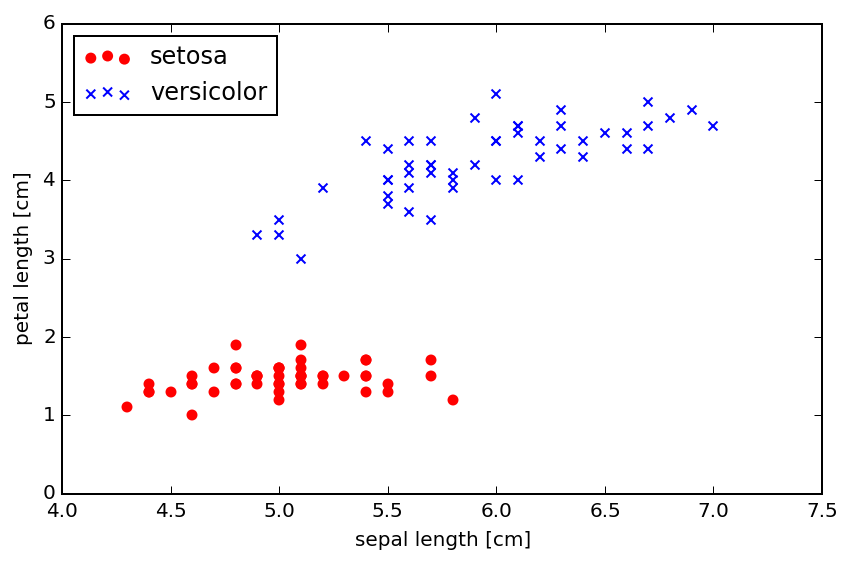

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.scatter(setosa_rows[:,0], setosa_rows[:,1],
            color='red', marker='o', label='setosa')
plt.scatter(versicolor_rows[:, 0], versicolor_rows[:, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Training the model

Let's implement the perceptron. We want to see how the weights and error rate progresses during iterations of training so our training function will also provide insight into that.

Note: I diverged from the author's implementation to a perhaps cleaner solution using a higher order function instead of a class, and also instrumented it to return a log of the weights across iterations so we can visualize how the fit improved with each iteration. I also break once there are no errors found instead of continuing to iterate mindlessly after converging.

In [4]:
# %load perceptron.py
"""
Implementation of perceptron algorithm from Chapter 2 of "Python Machine Learning"
"""
import numpy as np


def train_perceptron(observations, labels, learning_rate=0.1, max_training_iterations=10):
    """
    Trains a (binary) perceptron, returning a function that can predict / classify
    given a new observations, as well as insight into how the training progressed via
    a log of the weights and number of errors for each iteration.

    :param observations: array of rows
    :param labels: correct label classification for each row: [1, -1, 1, 1, ...]
    :param learning_rate: how fast to update weights
    :param max_training_iterations: max number of times to iterate through observations
    :return: (prediction_fn, weights_log, errors_log)
    """
    the_weights = np.zeros(1 + observations.shape[1])
    weights_log = []
    errors_log = []

    def net_input(observation, weights):
        return np.dot(observation, weights[1:]) + weights[0]

    def predict(observation, weights=the_weights):
        return np.where(net_input(observation, weights) >= 0.0, 1, -1)

    for _ in range(max_training_iterations):
        errors = 0
        weights_log.append(np.copy(the_weights))
        for observation, correct_output in zip(observations, labels):
            weight_delta = learning_rate * (correct_output - predict(observation))
            the_weights[1:] += weight_delta * observation
            the_weights[0] += weight_delta
            errors += int(weight_delta != 0.0)
        errors_log.append(errors)
        if errors == 0:
            break

    return predict, weights_log, errors_log


Now let's use this function to train a perceptron using our data set:

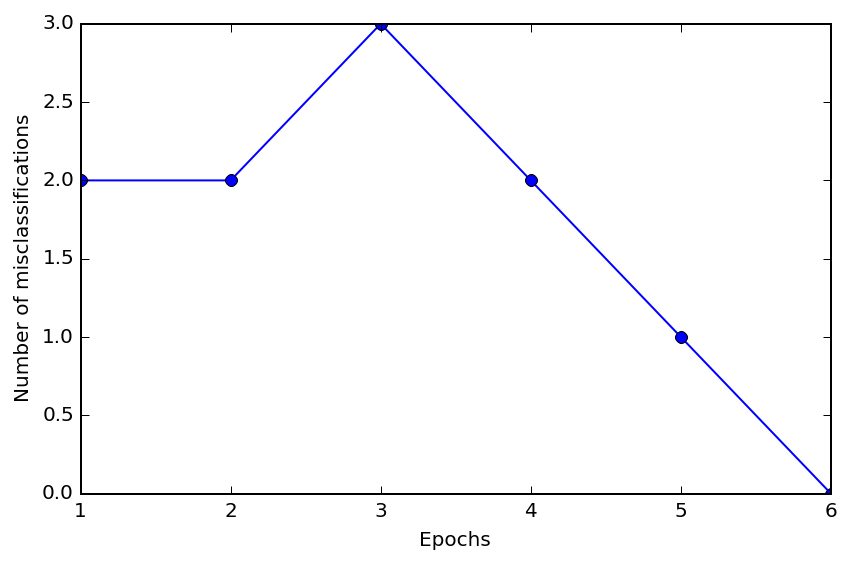

In [5]:
# select setosa and versicolor
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

ppn, weights_log, errors_log = train_perceptron(sepal_petal_rows, y)

plt.plot(range(1, len(errors_log) + 1), errors_log, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')

plt.tight_layout()
plt.show()

Notice that the training converges and has zero errors by the last iteration.

Let's visualize the decision regions of the final solution.

In [6]:
# %load decision_region_plot.py
"""
Helper function for plotting decision regions from Chapter 2 of Python Machine Learning.
"""

from matplotlib.colors import ListedColormap


def plot_decision_regions(plt, observations, labels, predict_fn, weights, resolution=0.02,
                          xlabel='sepal length [cm]', ylabel='petal length [cm]'):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(labels))])

    # plot the decision surface
    x1_min, x1_max = observations[:, 0].min() - 1, observations[:, 0].max() + 1
    x2_min, x2_max = observations[:, 1].min() - 1, observations[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = predict_fn(np.array([xx1.ravel(), xx2.ravel()]).T, weights)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(labels)):
        plt.scatter(x=observations[labels == cl, 0], y=observations[labels == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()


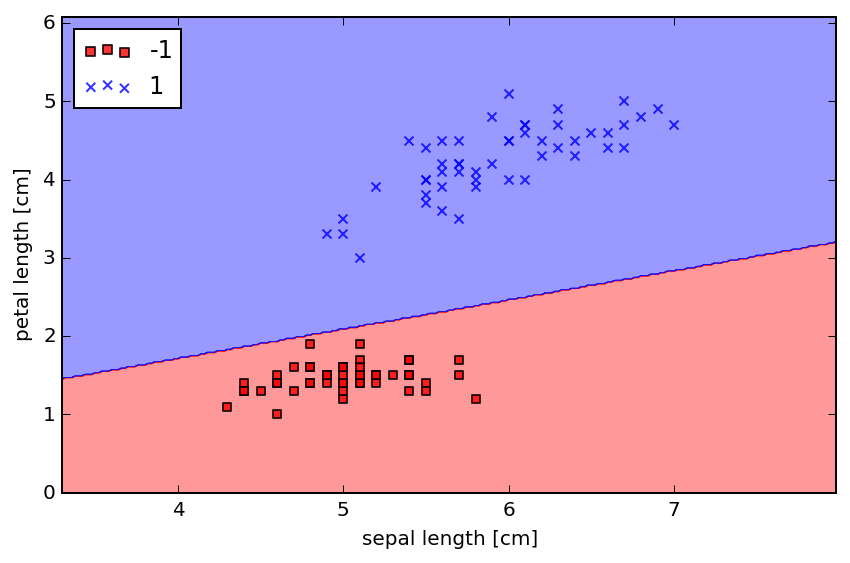

In [7]:
plot_decision_regions(plt, sepal_petal_rows, y, ppn, weights_log[-1])

Now let's see how the decision region improved over the iterations

after 0 iteration there are 2 errors using these weights:
[ 0.  0.  0.]


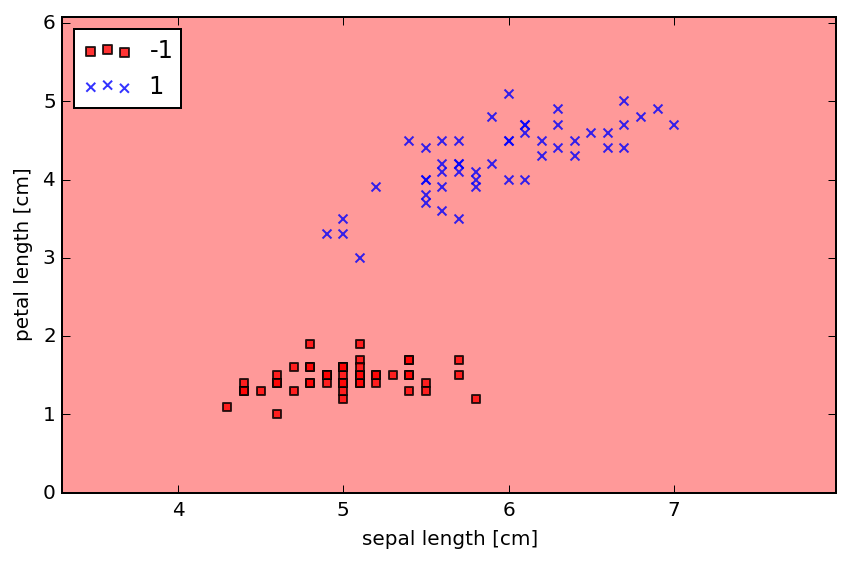

after 1 iteration there are 2 errors using these weights:
[ 0.    0.38  0.66]


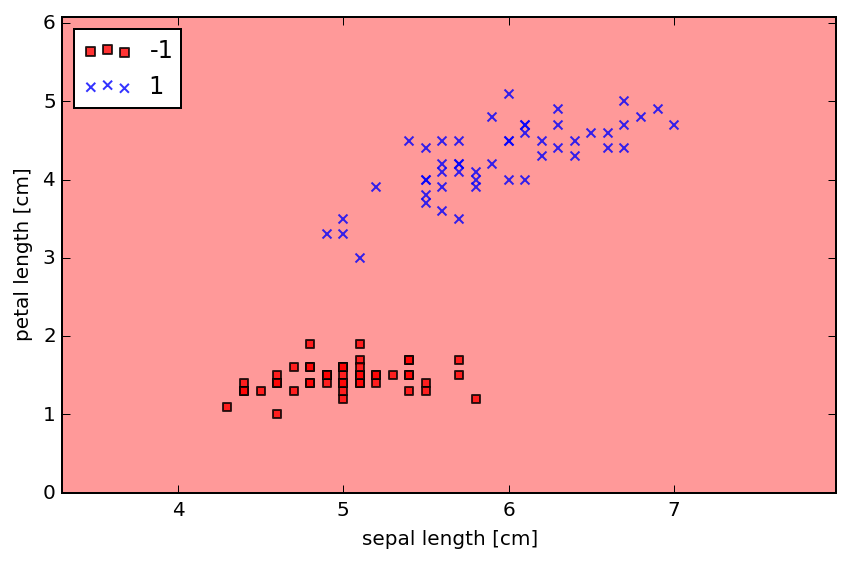

after 2 iteration there are 3 errors using these weights:
[ 0.    0.76  1.32]


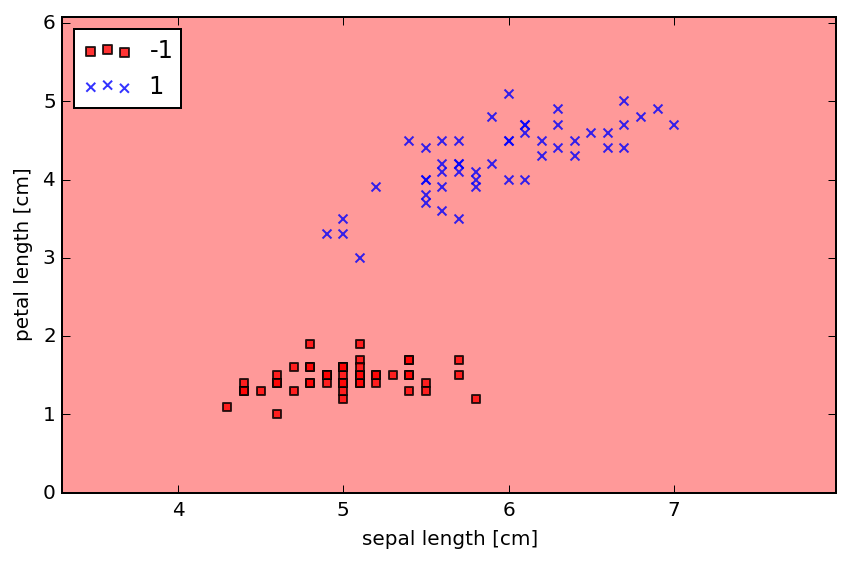

after 3 iteration there are 2 errors using these weights:
[-0.2   0.22  1.68]


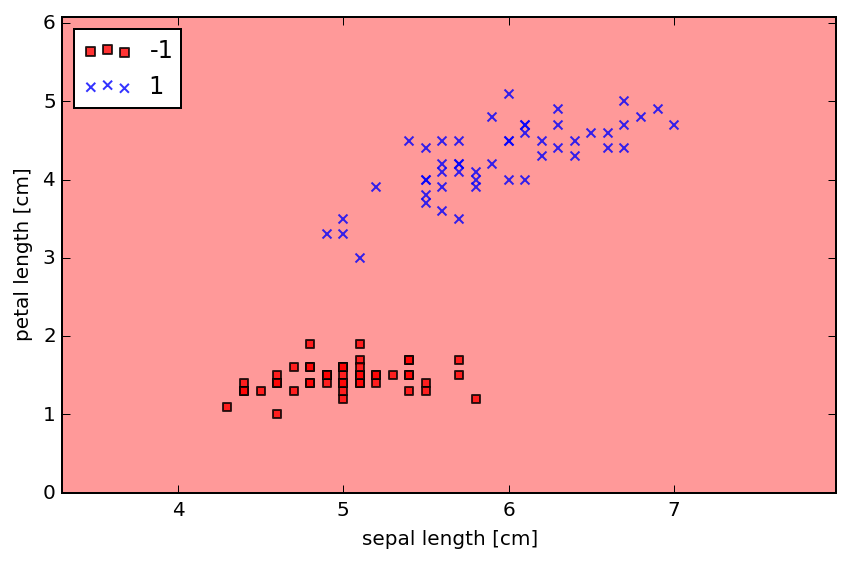

after 4 iteration there are 1 errors using these weights:
[-0.2   0.34  2.1 ]


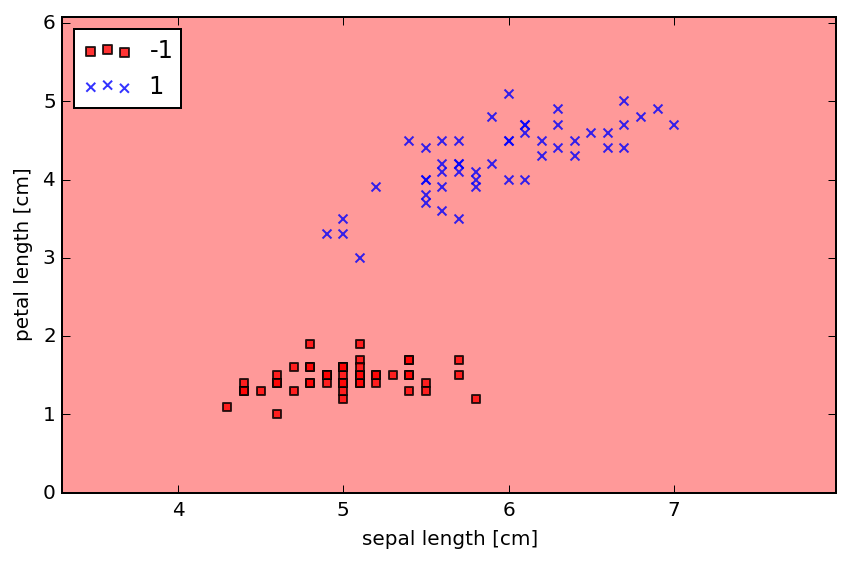

after 5 iteration there are 0 errors using these weights:
[-0.4  -0.68  1.82]


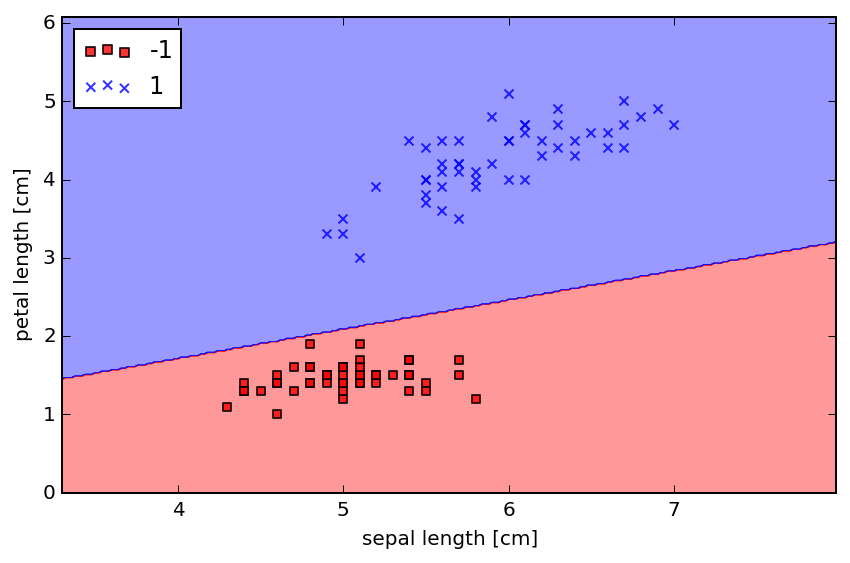

In [8]:
for i, (weights, num_errors) in enumerate(zip(weights_log, errors_log)):
    print("after %d iteration there are %d errors using these weights:\n%s" % (i, num_errors, weights))
    plot_decision_regions(plt, sepal_petal_rows, y, ppn, weights)

I'm confused as to why the decision regions are plotted 100% red until the solution converges, I would expect that it would show where the weights are recognizing correctly and not. However, I don't want to get bogged down, so moving on.

Update: after digging in a bit, snapshotting the weights each loop doesn't really work since they are updated iteratively in the inner loop as the observations are evaluated, so the number of errors won't be reproduced with the weights snapshot. Below, when we use batch gradient descent with Adeline, the weights log will allow us to plot the improving decision regions.

## Adaptive learning and gradient descent

We can do better by training based on the output before it has been quantized, and doing so in batches.

In [9]:
# %load adeline.py
"""
Implementation of ADAptive LInear NEuron (Adaline) algorithm from Chapter 2 of
"Python Machine Learning"
"""
import numpy as np


def train_adeline(observations, labels, learning_rate=0.0001, max_training_iterations=100):
    """
    Trains a (binary) perceptron, returning a function that can predict / classify
    given a new observations, as well as insight into how the training progressed via
    a log of the weights and squared errors for each iteration.

    :param observations: array of rows
    :param labels: correct label classification for each row: [1, -1, 1, 1, ...]
    :param learning_rate: how fast to update weights
    :param max_training_iterations: max number of times to iterate through observations
    :return: (prediction_fn, weights_log, errors_log)
    """
    the_weights = np.zeros(1 + observations.shape[1])
    weights_log = []
    num_errors_log = []
    squared_error_log = []

    def net_input(observations, weights):
        return np.dot(observations, weights[1:]) + weights[0]

    def quantized_output(output):
        return np.where(output >= 0.0, 1, -1)

    def predict(observations, weights=the_weights):
        return quantized_output(net_input(observations, weights))

    for _ in range(max_training_iterations):
        weights_log.append(np.copy(the_weights))
        raw_outputs = net_input(observations, the_weights)
        errors = labels - raw_outputs
        weight_deltas = learning_rate * np.dot(observations.transpose(), errors)
        the_weights[1:] += weight_deltas
        the_weights[0] += learning_rate * np.sum(errors)

        squared_errors = (errors ** 2).sum() / 2.0
        num_errors = (quantized_output(raw_outputs) != labels).sum()
        squared_error_log.append(squared_errors)
        num_errors_log.append(num_errors)
        if num_errors == 0:
            break

    return predict, weights_log, squared_error_log, num_errors_log


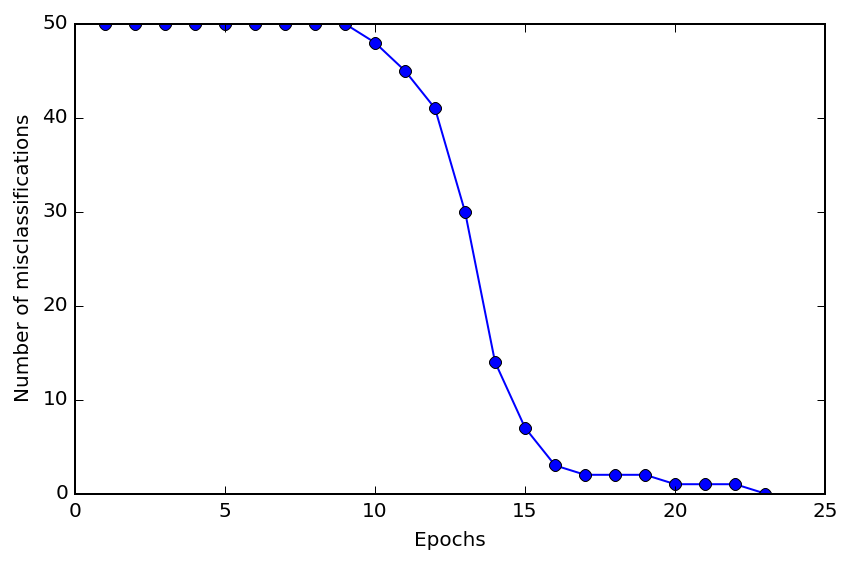

In [10]:
adeline, weights_log, squared_error_log, num_errors_log = train_adeline(sepal_petal_rows, y)

plt.plot(range(1, len(num_errors_log) + 1), num_errors_log, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')

plt.tight_layout()
plt.show()

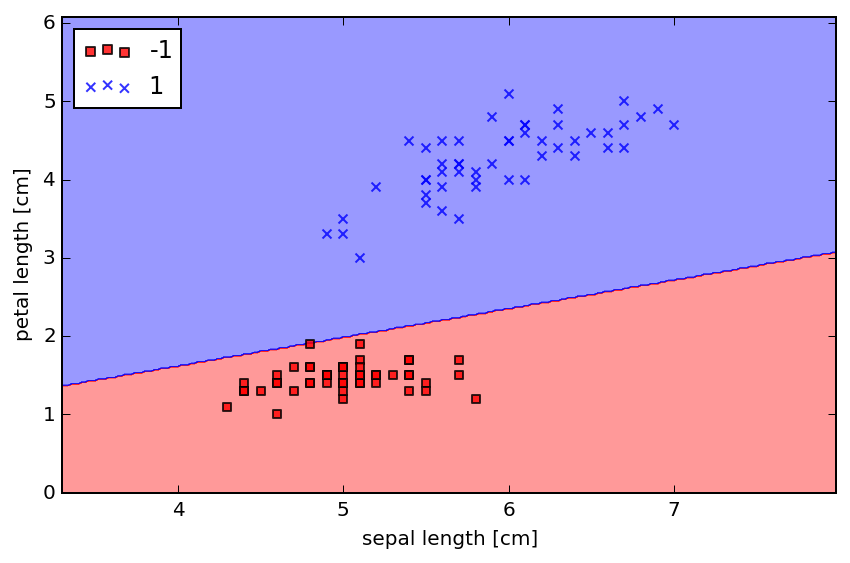

In [11]:
plot_decision_regions(plt, sepal_petal_rows, y, adeline, weights_log[-1])

Let's examine how the learning rate for gradient descent influences convergance: with a learning rate of 0.01, the error increases, whereas with a learning rate of .0001 it doesn't.

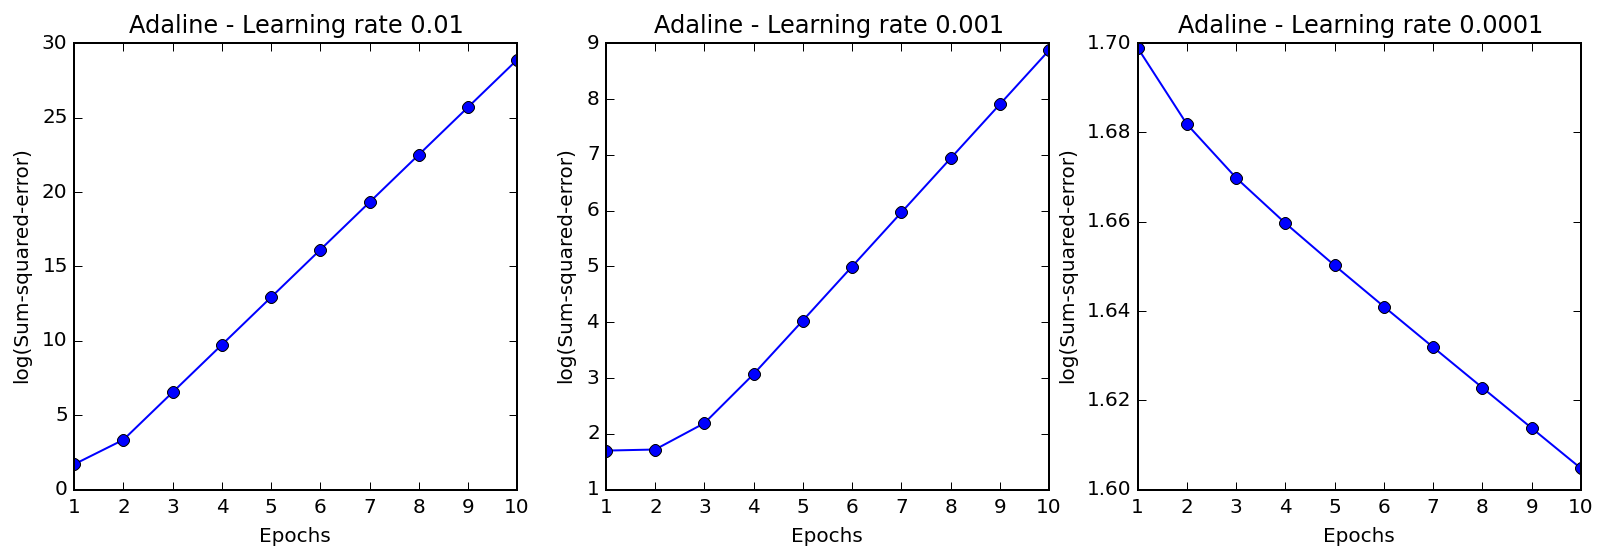

In [12]:
learning_rates = [.01, .001, .0001]

fig, ax = plt.subplots(nrows=1, ncols=len(learning_rates), figsize=(4.5*len(learning_rates), 4))

for i, learning_rate in enumerate(learning_rates):
    adeline, weights_log, squared_error_log, num_errors_log = train_adeline(
        sepal_petal_rows, y, 
        learning_rate=learning_rate, 
        max_training_iterations=10)
    ax[i].plot(range(1, len(squared_error_log) + 1), np.log10(squared_error_log), marker='o')
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('log(Sum-squared-error)')
    ax[i].set_title('Adaline - Learning rate %s' % learning_rate)
    
plt.show()

### Feature scaling to increase learning speed

It's kind of a bummer to have to hunt and peck for a learning rate that will converge. If we scale the features before training, we can get away with a learning rate of 0.01, and get convergence after just 3 iterations!

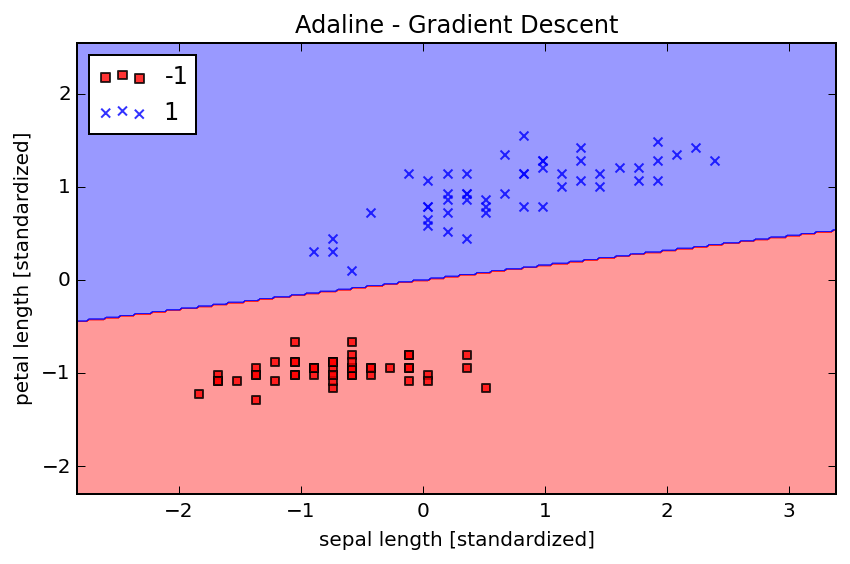

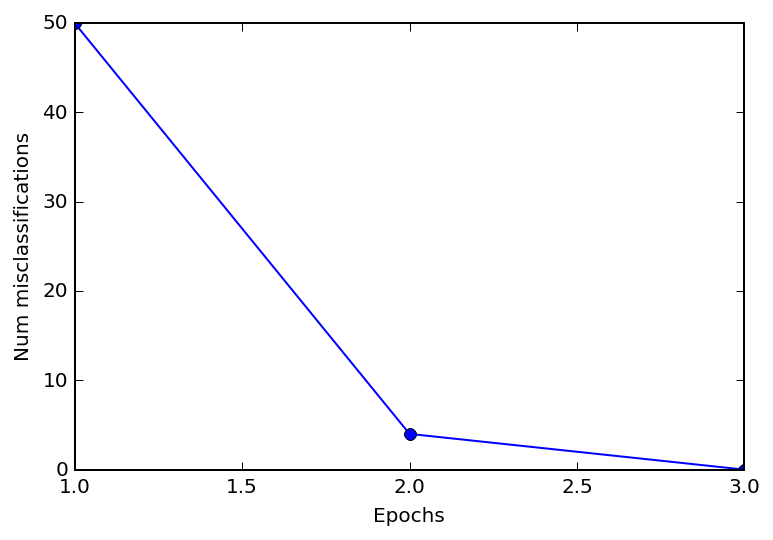

In [13]:
sepal_petal_rows_std = np.copy(sepal_petal_rows)
for i in range(sepal_petal_rows_std.shape[1]):
    sepal_petal_rows_std[:, i] = (sepal_petal_rows[:,i] - sepal_petal_rows[:,i].mean()) / sepal_petal_rows[:,i].std()

adeline, weights_log, squared_error_log, num_errors_log = train_adeline(sepal_petal_rows_std, y, learning_rate=0.01)
plt.title('Adaline - Gradient Descent')
plot_decision_regions(
    plt, sepal_petal_rows_std, y, adeline, weights_log[-1],
    xlabel = 'sepal length [standardized]',
    ylabel = 'petal length [standardized]')

plt.plot(range(1, len(num_errors_log) + 1), num_errors_log, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Num misclassifications')
plt.show()


Finally, as promised above, we can plot how the decision boundary improves with each iteration:

after 0 iteration there are 50 errors using these weights:
[ 0.  0.  0.]


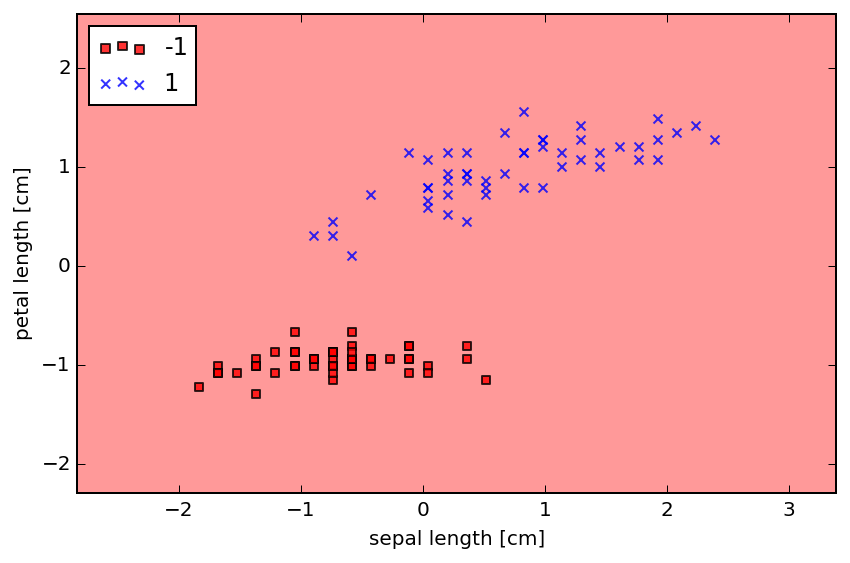

after 1 iteration there are 4 errors using these weights:
[ 0.          0.72829015  0.96995527]


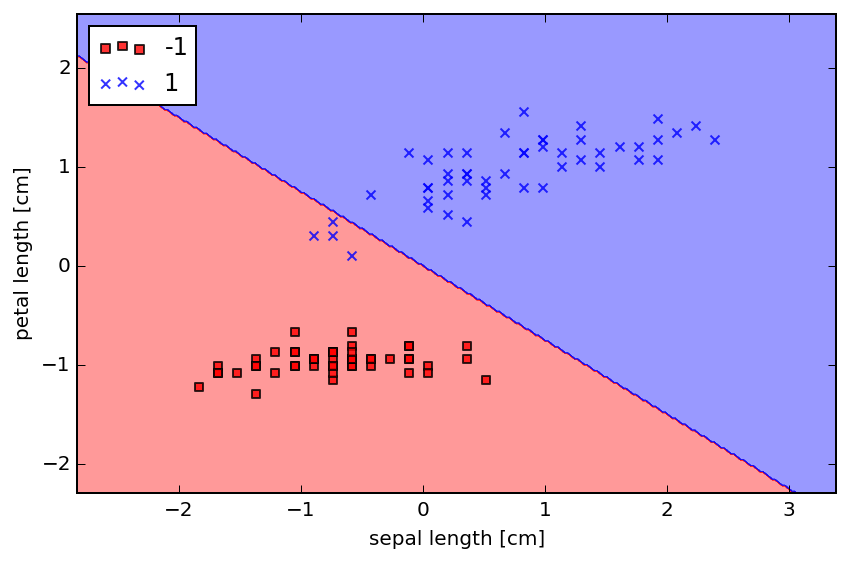

after 2 iteration there are 0 errors using these weights:
[  1.49658064e-15  -5.96910515e-02   3.78300208e-01]


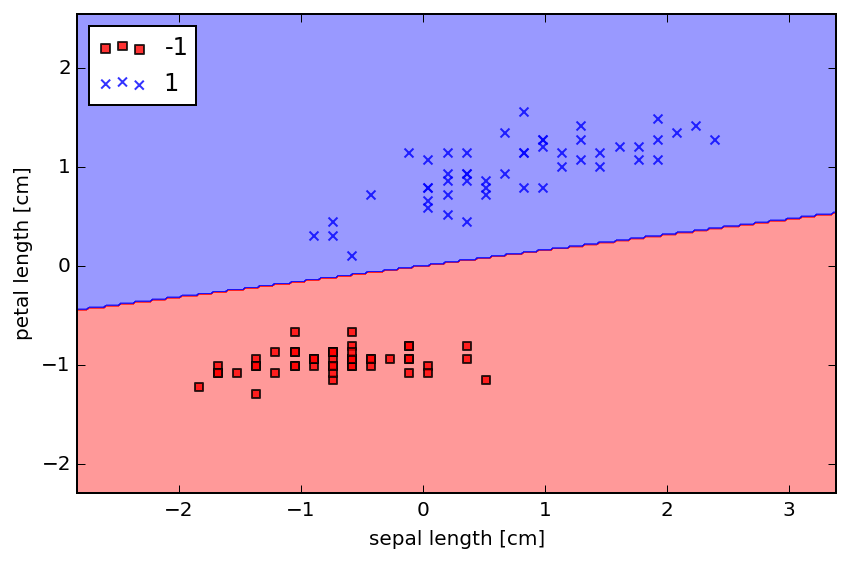

In [14]:
for i, (weights, num_errors) in enumerate(zip(weights_log, num_errors_log)):
    print("after %d iteration there are %d errors using these weights:\n%s" % (i, num_errors, weights))
    plot_decision_regions(plt, sepal_petal_rows_std, y, adeline, weights)